In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import numpy as np

In [6]:
#select two parameters (column_1 and column_2) to regress against price, will also include points
#x_rank is number of top highest of each of the categories
#percentile is cut off at which highest prices are removed

#example:  RegressWines('country', 'variety', 6, 99):
#takes the top 6 countries and top 6 varities and points (score), and removes the retains the bottom 99% of prices in distribution and regresses to predict prices
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']

def DeepLearnWines(column_1, column_2, x_ranks, percentile, price_bucket_range):

    #import first 150k reviews, and second 130k reviews
    review1 = pd.read_csv(os.path.join('Data/winemag-data_first150k.csv'))
    review2 = pd.read_csv(os.path.join('Data/winemag-data-130k-v2.csv'))

    #concatenate both dataframes by common columns
    review_df = pd.concat([review1, review2], sort=False)

    #drop unnamed index columns
    review_df = review_df.drop(['Unnamed: 0'], axis=1)

    #reduce reviews to columns we want to regress against
    model_df = review_df[['country', 'points', 'variety', 'price', 'winery']]

    #drop NaN values
    model_df = model_df.dropna()

    #print total number of starting data points
    print(f"Starting data points for analysis: {len(model_df)}")    

    #list top 6 countries
    countries = ['US', 'Italy', 'France', 'Spain', 'Chile', 'Portugal']
    
    #reduce dataframe to contain only six countries
    model_df = model_df[model_df['country'].isin(countries)]
    
    #create list of top 3 wineries in each of top 6 countries
    wineries = []
    for country in countries:
        country_wineries = model_df[model_df['country']==country]['winery'].value_counts().head(3).index.tolist()
        wineries.append(country_wineries)
    
    #create flat list of wineries from list of sublists
    flat_list = [item for sublist in wineries for item in sublist]
    
    #list top x ranked items from column_2 and place in list to train data set
    category_2 = pd.DataFrame(model_df[column_2].value_counts().head(x_ranks))
    category_2 = category_2.index.tolist()

    #reduce dataframe to contain only data points in top x_rank from columns 1 and columns 2 selected
    model_df = model_df.loc[model_df['winery'].isin(flat_list)]
    model_df = model_df.loc[model_df[column_2].isin(category_2)]

    #print remaining number of data points
    print(f"Filtered Data Points: {len(model_df)}") 
    print("-"*60)
    print(column_1)
    print(flat_list)
    print("-"*60)
    print(column_2)
    print(category_2)
    print("-"*60)

    #max price is definded as percentile cutoff
    print(f"Starting Max Price = {model_df['price'].max()}")
    max_price = np.percentile(model_df['price'], percentile)
    
    #remove top (100-percentile) of prices
    model_df = model_df.loc[model_df['price']<= max_price]

    #print new max price
    print(f"New Max Price = {model_df['price'].max()}")

    number_of_buckets = 4
    price_buckets = []
          
    if price_bucket_range=="uniform":
        for i in range (1,number_of_buckets):
            percentile = i*100/number_of_buckets
            price = np.percentile(model_df['price'], percentile)
            price_buckets.append(price)
            print(f"Percentile: {percentile}; Price: {price}")
    
    elif price_bucket_range=="extreme":
        percentile = [5, 50, 95]
        for i in range(0, len(percentile)):
            price = np.percentile(model_df['price'], percentile[i])
            price_buckets.append(price)
            print(f"Percentile: {percentile[i]}; Price: {price}")
    
    model_df['price_dummy'] = model_df['price'].apply(lambda x: 0 if x < price_buckets[0] else (1 if x < price_buckets[1] else (2 if x < price_buckets[2] else 3)))      
          
    #define X and y parameters
    X = model_df[['points', column_1, column_2]]
    y = model_df["price_dummy"].values.reshape(-1, 1)

    #mirror X into data to assign categorical values
    data = X.copy()

    # using get_dummies with a single column
    X = pd.get_dummies(data, columns=[column_1, column_2])

    #define training and testing variables
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.preprocessing import StandardScaler
    from keras.utils import to_categorical

    # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # Transform the training and testing data using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    # first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
    from keras.models import Sequential
    from keras.layers import Dense

    input_dim_n = len(X.columns.tolist())

    deep_model = Sequential()
    deep_model.add(Dense(units=10, activation='relu', input_dim=input_dim_n))
    deep_model.add(Dense(units=10, activation='relu'))
    deep_model.add(Dense(units=number_of_buckets, activation='softmax'))

    deep_model.summary()

    deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    history =  deep_model.fit(
        X_test_scaled,
        y_test_categorical,
        validation_split=0.33, epochs=30, batch_size=10, verbose=0
    )        

    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
          
    return history
          

Starting data points for analysis: 258145
Filtered Data Points: 2738
------------------------------------------------------------
winery
['Williams Selyem', 'Testarossa', 'Chateau Ste. Michelle', 'Feudi di San Gregorio', 'Planeta', 'Tommasi', 'Louis Latour', 'Joseph Drouhin', 'Bouchard Père & Fils', 'Marqués de Cáceres', 'Torres', 'Bodegas Valdemar', 'Concha y Toro', 'Montes', 'Santa Ema', 'DFJ Vinhos', 'Wines & Winemakers', 'Companhia das Quintas']
------------------------------------------------------------
variety
['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Syrah', 'Bordeaux-style Red Blend']
------------------------------------------------------------
Starting Max Price = 757.0
New Max Price = 757.0
Percentile: 5; Price: 12.0
Percentile: 50; Price: 48.0
Percentile: 95; Price: 160.60000000000036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1

C:\Users\marky\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


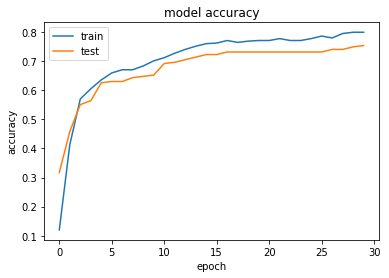

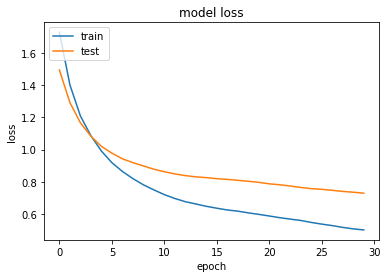

In [8]:
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']
#5th argument is price bucket range either extreme or uniform
DeepLearnWines('winery', 'variety', 6, 100, "extreme")